In [15]:
library(magrittr)
library(data.table)
library(dplyr)
library(tidyr)
library(ggsci)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
#library(ggseqlogo)
library(MVLM)
library(jsonlite)
library(readr)
library(sparklyr)

ERROR: Error in library(sparklyr): there is no package called 'sparklyr'


In [16]:
install.packages("sparklyr")

Installing package into '/home/sukmb667/R/x86_64-pc-linux-gnu-library/4.1'
(as 'lib' is unspecified)

also installing the dependency 'xml2'


Warning message in system2(cmd0, args, env = env, stdout = outfile, stderr = outfile, :
"system call failed: Cannot allocate memory"
Warning message in system2(cmd0, args, env = env, stdout = outfile, stderr = outfile, :
"error in running command"
Warning message in install.packages("sparklyr"):
"installation of package 'xml2' had non-zero exit status"
Warning message in system2(cmd0, args, env = env, stdout = outfile, stderr = outfile, :
"system call failed: Cannot allocate memory"
Warning message in system2(cmd0, args, env = env, stdout = outfile, stderr = outfile, :
"error in running command"
Warning message in install.packages("sparklyr"):
"installation of package 'sparklyr' had non-zero exit status"


In [4]:
# IMGT database

database <- fromJSON('imgt.202312-3.sv8.json')[[5]][[8]]
database <- extract(database, uri, into = c('fasta', 'gene'), regex = "(.*)#(.*)", remove = TRUE)

database_tcr <- filter(database, (grepl('TRBJ', gene) | grepl('TRBV', gene))) %>% 
  select(gene, sequence)

database_tcr_v <- filter(database_tcr, grepl('TRBV', gene)) %>% 
  mutate(gene_number = sub('TRBV','', gene)) %>%
  separate(gene_number, into = c('gene_number', 'allele'), sep = '\\*', remove = T) %>%
  separate(gene_number, into = c('gene_number', 'transcript'), sep = '-', remove = T)
database_tcr_v <- replace_na(database_tcr_v, list(transcript = '1'))
database_tcr_v$gene_number <- sprintf('%02s', c(database_tcr_v$gene_number))
database_tcr_v$transcript <- sprintf('%02s', c(database_tcr_v$transcript))
database_tcr_v <- database_tcr_v %>% mutate(vGeneName = paste0(paste0(paste0('TCRBV',gene_number),'-'),transcript))
  


database_tcr_j <- filter(database_tcr, grepl('TRBJ', gene)) %>%
  mutate(gene_number = sub('TRBJ','', gene)) %>%
  separate(gene_number, into = c('gene_number', 'allele'), sep = '\\*', remove = T) %>%
  separate(gene_number, into = c('gene_number', 'transcript'), sep = '-', remove = T)
database_tcr_j <- replace_na(database_tcr_j, list(transcript = '1'))
database_tcr_j$gene_number <- sprintf('%02s', c(database_tcr_j$gene_number))
database_tcr_j$transcript <- sprintf('%02s', c(database_tcr_j$transcript))
database_tcr_j <- database_tcr_j %>% mutate(jGeneName = paste0(paste0(paste0('TCRBJ',gene_number),'-'),transcript))


#-------------V and J germ-line database-----

#AAs encoded in V gene germline sequences
V_germ_line <- read.table("data/V_exclude_AA.info",
                          header=T,colClasses="character")
V_germ_line$IMGT <- paste0("P",V_germ_line$IMGT)
V_exclude <- paste0(V_germ_line$Vgene,":",V_germ_line$IMGT,":",V_germ_line$AA)

#AAs encoded in J gene germline sequences (we need to consider CDR3 length for J genes)
J_germ_line <- read.table("data/J_exclude_AA.info",
                          header=T,colClasses="character")
J_germ_line$IMGT <- paste0("P",J_germ_line$IMGT)
J_exclude <- paste0(J_germ_line$Jgene,':',J_germ_line$Length,":",J_germ_line$IMGT,":",J_germ_line$AA)





Warning message:
"Expected 2 pieces. Missing pieces filled with `NA` in 31 rows [1, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, ...]."


In [7]:


#-------all IMGT positions--------
all_imgt_pos <- c(
  "P104","P105","P106","P107","P108","P109","P110","P111",
  "P111.1","P112.2","P112.1",
  "P112","P113","P114","P115","P116","P117","P118")
length(all_imgt_pos)


#-------Custom function to align CDR3 AA seq to IMGT------
align_imgt <- function(CDR3){
  AA <- unlist(strsplit(CDR3, ""));
  N_AA_fow <- nchar(CDR3) %/% 2 + nchar(CDR3) %% 2;
  N_AA_na <- 18 - nchar(CDR3);
  AAmod <- c(
    AA[1:(N_AA_fow)],
    rep("NA",N_AA_na),
    AA[(N_AA_fow + 1):nchar(CDR3)]
  );
  names(AAmod) <- all_imgt_pos
  return(t(AAmod))
}

cdr3_read <- function(){
    
    #---get a list of patients-------
    individuals_to_match <- list.files('data/CMV')[grep('.tsv', list.files('data/CMV'))]
    individuals_to_match <- individuals_to_match[grep('P', individuals_to_match)]
    cdr3_data <- data.frame(matrix(ncol= 8, nrow = 0))
    colnames(cdr3_data) <- c('patient_id_Emerson', 'rearrangement', 'amino_acid', 'v_family', 'v_gene', 'j_family', 'j_gene', 'cdr3_length')

    for (indiv in individuals_to_match){
        
        tdata <- read.csv(paste0("data/CMV/",indiv), sep= '\t', header = T, colClasses = 'character')  %>% 
            select(c(rearrangement, amino_acid, v_family, v_gene, j_family, j_gene, cdr3_length)) %>% 
            mutate(func = ifelse((grepl('\\*', amino_acid) | amino_acid == ''), 'non_productive', 'productive')) %>%
            mutate(patient_id_Emerson = substr(indiv, 4, 6)) %>%
            filter(func == 'productive') %>% 
            filter((cdr3_length>=36) & (cdr3_length<=54)) %>% 
            filter(substr(amino_acid,1,1)=='C' & substr(amino_acid,nchar(amino_acid),nchar(amino_acid))=='F') %>%
            filter(v_gene != '') %>%
            filter(v_gene %in% unique(V_germ_line$Vgene)) %>%
            filter(j_gene %in% unique(J_germ_line$Jgene)) %>%
            mutate(length = nchar(amino_acid)) %>%
            select(patient_id_Emerson, amino_acid, v_gene, j_gene, length, func)
        cdr3_data <- rbind(cdr3_data, tdata)
        }

    return(cdr3_data)
    
}
    
#----------column of CDR3s starts with C and ends with F------------
imgt_pivot <- function(tdata){    
    tdata_productive_subseting <- tdata %>% 
      dplyr::filter(func == 'productive') %>% 
      dplyr::filter((length>=12) & (length<=18)) %>% 
      dplyr::filter(substr(amino_acid,1,1)=='C' & substr(amino_acid,nchar(amino_acid),nchar(amino_acid))=='F') %>%
      dplyr::filter(v_gene != '') %>%
      dplyr::filter(v_gene %in% unique(V_germ_line$Vgene)) %>%
      dplyr::filter(j_gene %in% unique(J_germ_line$Jgene)) %>%
      select(patient_id_Emerson, amino_acid, v_gene, j_gene, length)
    
    #Add imgt position data to tdata_qc
    tdata_imgt_pos <- t(sapply(as.character(tdata_productive_subseting$amino_acid),align_imgt))
    colnames(tdata_imgt_pos) <- all_imgt_pos
    tdata_qc_imgt <- data.frame(tdata_productive_subseting,tdata_imgt_pos)
    
    #--------my part with excluding the germ line AA----
    tdata_qc_imgt_pivot_long <- tdata_qc_imgt %>% pivot_longer(all_of(all_imgt_pos), names_to = 'IMGT', values_to = 'AA')
    tdata_qc_imgt_pivot_long$v_pos_aa <- paste0(tdata_qc_imgt_pivot_long$v_gene,":",tdata_qc_imgt_pivot_long$IMGT,":",tdata_qc_imgt_pivot_long$AA)
    tdata_qc_imgt_pivot_long$j_len_pos_aa <- paste0(tdata_qc_imgt_pivot_long$j_gene,":",tdata_qc_imgt_pivot_long$length, ':', tdata_qc_imgt_pivot_long$IMGT,":",tdata_qc_imgt_pivot_long$AA)
    tdata_qc_imgt_pivot_long_excluded_germ <- tdata_qc_imgt_pivot_long %>%
      filter(!(v_pos_aa %in% V_exclude)) %>%
      filter(!(j_len_pos_aa %in% J_exclude)) %>%
      filter(!(AA == 'NA')) %>%
      select(patient_id_Emerson,amino_acid, length, IMGT, AA)
   

    #--------density of pos_length coverage-------
    
    tdata_pivot_pos_length_density <- tdata_qc_imgt_pivot_long_excluded_germ %>%
      select(patient_id_Emerson,length, IMGT) %>%
      group_by(patient_id_Emerson,length, IMGT) %>%
      count()
    
    tdata_pivot_pos_length_aa_freq <- tdata_qc_imgt_pivot_long_excluded_germ %>%
      select(patient_id_Emerson,length, IMGT,AA) %>%
      group_by(patient_id_Emerson,length, IMGT) %>%
      count(AA) %>%
      mutate(total_per_length_position = sum(n)) %>%
      filter(total_per_length_position >= 18)
    
    tdata_pivot_pos_length_aa_freq$relativ_freq <- tdata_pivot_pos_length_aa_freq$n / tdata_pivot_pos_length_aa_freq$total_per_length_position
    tdata_pivot_pos_length_aa_freq <- tdata_pivot_pos_length_aa_freq %>% 
      group_by(patient_id_Emerson,length, IMGT) %>% 
      mutate(sum_freq = sum(relativ_freq))

    return(tdata_pivot_pos_length_aa_freq)
  }

    
    ###continuation from the cdr3-qtl atricle----
    #we transformed each amino acid frequency into a standard normal distribution (INT-transform).
    #we used this transformed data as in many other eQTL studies.
cdr3_matrix <- function(tdata_pivot_pos_length_aa_freq){ 
    
    pall <- data.frame()
    #tdata_pivot_pos_length_aa_freq$pos_length <- paste0(tdata_pivot_pos_length_aa_freq$IMGT, ':',tdata_pivot_pos_length_aa_freq$length)
    pdata <- tdata_pivot_pos_length_aa_freq
    pnamelist <- unique(pdata$AA)
    
    for (ptarget in pnamelist){
      pdata2 <- subset(pdata, AA==ptarget)
      pdata2 <- pdata2[,c("patient_id_Emerson", "relativ_freq")]
      x <- pdata2$relativ_freq
      pdata2$normrate <- qnorm((rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
      
      df <- pdata2[,c("patient_id_Emerson","normrate")]
      df$AA <- ptarget
      pall <- rbind(pall,df)
    }
    
    
    #transform pall into a matrix
    #-------check the logic-----------
    mat <- matrix(0, nrow=length(unique(pall$patient_id_Emerson)), ncol = length(unique(pall$AA)))
    row.names(mat) <- unique(pall$patient_id_Emerson)
    colnames(mat) <- unique(pall$AA)
    
    for( i in unique(pall$patient_id_Emerson) ){
      for( k in unique(pall$AA) ){
        out <- subset(pall, patient_id_Emerson==i & AA==k)
        if( nrow(out) ==1 ){
          mat[i,k] <- out$normrate
        }else{
          mat[i,k] <- 0
        }
      }
    }
    mat <- data.frame(patient_id_Emerson=row.names(mat),mat)
    return(mat)
}

[1] 18

In [4]:
cdr3 <- cdr3_read()
write_tsv(cdr3, 'cdr3.tsv')

In [1]:
cdr3 <- read.csv2('cdr3.tsv', sep = '\t', header = TRUE)

In [8]:
pivoted_cdr3 <- imgt_pivot(cdr3)
write_tsv(cdr3, 'cdr3.tsv')

ERROR: Error: cannot allocate vector of size 10.0 Gb


In [5]:
tail(pivoted_cdr3)

,patient_id_Emerson,amino_acid,v_gene,j_gene,length,func
,<int>,<chr>,<chr>,<chr>,<int>,<chr>
96965876,668,CASSTGTFMNTEAFF,TCRBV07-03,TCRBJ01-01,15,productive
96965877,668,CASSPGTDNEQFF,TCRBV07-03,TCRBJ02-01,13,productive
96965878,668,CASSLNGGNSYNEQFF,TCRBV07-03,TCRBJ02-01,16,productive
96965879,668,CASSQQGGSEQYF,TCRBV07-03,TCRBJ02-07,13,productive
96965880,668,CASSFQPGREQYF,TCRBV07-03,TCRBJ02-07,13,productive
96965881,668,CASSRTGPGTEAFF,TCRBV07-03,TCRBJ01-01,14,productive


### preparing cdr3 matrix for 34 patients of CDR3s length 13 position P107

In [15]:
cdr3_34 <- read.csv2('cdr3.tsv', sep = '\t', header = TRUE, nrow = 5000000)
pivoted_cdr3_34 <- imgt_pivot(cdr3_34)
write_tsv(pivoted_cdr3_34, 'pivoted_cdr3_subset_34_patients.tsv')

In [17]:
write_tsv(pivoted_cdr3, 'pivoted_cdr3_subset_34_patients.tsv')

In [20]:
pivoted_cdr3_L13_P107 <- pivoted_cdr3 %>% filter(length == 13 & IMGT == 'P107')
pivoted_cdr3_matrix <- cdr3_matrix(pivoted_cdr3_L13_P107)

In [33]:
pivoted_cdr3_matrix

,patient_id_Emerson,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.18536702,-1.11533736,0.98723099,0.77020808,-0.77020808,-0.33809166,-0.87356913,0.26096740,0.26096740,...,1.26496924,1.44999891,1.44999891,0.18536702,-1.26496924,-0.38941430,0.26096740,-1.26496924,-0.58458986,1.44999891
2,2,1.11533736,-0.26096740,-0.77020808,-1.70478090,0.18536702,-0.41728414,1.26496924,0.67448975,0.58458986,...,-1.26496924,1.11533736,-1.44999891,-0.03687053,0.87356913,1.43420016,-0.33809166,-0.33809166,-0.67448975,-1.44999891
3,3,-1.70478090,1.11533736,-1.11533736,1.26496924,0.03687053,-1.44999891,-0.98723099,1.70478090,1.11533736,...,0.49918784,-0.03687053,0.33809166,0.67448975,-0.41728414,-2.16610675,0.77020808,-0.03687053,0.58458986,-0.18536702
4,4,0.33809166,-0.49918784,0.33809166,0.26096740,-0.26096740,-0.26096740,-0.11081291,-0.67448975,-0.03687053,...,0.41728414,0.77020808,-0.49918784,0.87356913,-0.26096740,0.07603162,0.33809166,0.26096740,-0.18536702,-0.11081291
5,5,0.58458986,-0.41728414,2.17792307,1.44999891,1.44999891,1.44999891,0.67448975,0.98723099,-2.17792307,...,-1.44999891,-2.17792307,2.17792307,0.11081291,-2.17792307,0.38941430,-1.70478090,0.87356913,-0.41728414,1.11533736
6,6,-0.11081291,-1.26496924,0.03687053,-0.77020808,0.67448975,-0.98723099,-0.41728414,-2.17792307,1.26496924,...,0.87356913,1.70478090,-0.98723099,-0.67448975,0.67448975,-0.30866581,0.03687053,1.44999891,-1.11533736,-0.26096740
7,7,0.87356913,1.44999891,0.49918784,-0.18536702,-0.49918784,0.49918784,0.03687053,0.58458986,-1.11533736,...,-0.77020808,0.26096740,0.18536702,0.26096740,-0.03687053,-0.22988412,0.58458986,-0.58458986,-1.44999891,-0.98723099
8,8,2.17792307,0.33809166,1.26496924,-2.17792307,0.26096740,1.70478090,-2.17792307,0.87356913,-1.44999891,...,-1.70478090,-0.58458986,0.03687053,2.17792307,-0.98723099,2.16610675,-0.11081291,-0.87356913,-0.87356913,-0.49918784
9,9,-1.11533736,0.03687053,0.18536702,0.49918784,0.11081291,-0.58458986,-0.33809166,1.44999891,-0.33809166,...,0.33809166,-0.18536702,-0.18536702,0.58458986,-0.18536702,-0.85249503,-0.58458986,2.17792307,0.77020808,0.98723099


In [7]:

#tdata_nonProductive <- filter(tdata, (grepl('\\*', aminoAcid) | aminoAcid == ''))

  #mutate(v_3mer = substring(aminoAcid, 1, 3)) %>% 
  #mutate(v_2mer = substring(aminoAcid, 1, 2)) %>% 
  #mutate(j_3mer = substring(aminoAcid, nchar(aminoAcid)-2, nchar(aminoAcid))) %>%
  #mutate(j_2mer = substring(aminoAcid, nchar(aminoAcid)-1, nchar(aminoAcid)))

[1] 18

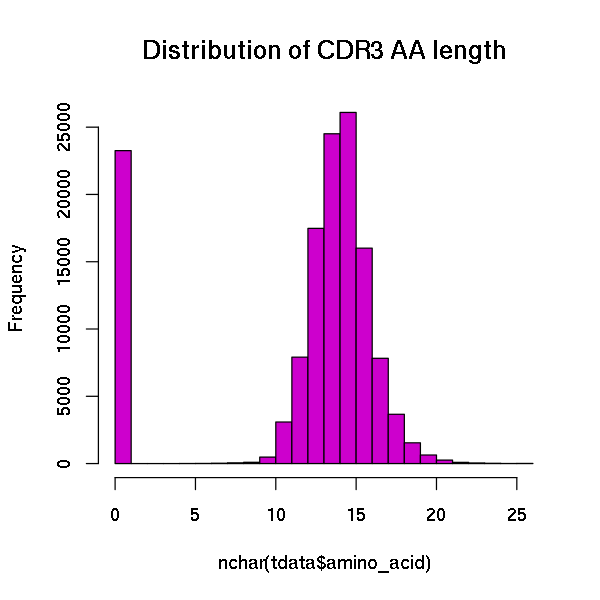

In [26]:

#tdata_productive_subseting_v <- tdata_productive_subseting %>% 
#  select(c(v_gene, v_part_3, aminoAcid)) %>% 
#  filter(vGeneName != '') %>%
#  group_by(vGeneName, v_part_3) %>%
#  mutate(overlaps_with_v_3mer = count(v_part_3))

#tdata_productive_subseting_j <- tdata_productive_subseting %>% 
#  select(c(vGeneName, v_part_3, aminoAcid)) %>% 
#  filter(vGeneName != '') %>%
#  group_by(vGeneName, v_part_3) %>%
#  mutate(overlaps_with_v_3mer = count(v_part_3))


options(repr.plot.width=5, repr.plot.height=5)
hist(nchar(tdata$amino_acid),breaks=20,main="Distribution of CDR3 AA length",col="magenta3")


In [9]:
head(cdr3)

[1] 15

P104,P105,P106,P107,P108,P109,P110,P111,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
C,A,T,T,G,T,S,G,NA,NA,NA,S,Q,S,T,Q,Y,F


,amino_acid,v_gene,j_gene,length,P104,P105,P106,P107,P108,P109,...,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CASSQGQGDFYGYTF,CASSQGQGDFYGYTF,TCRBV05-05,TCRBJ01-02,15,C,A,S,S,Q,G,...,NA,NA,NA,D,F,Y,G,Y,T,F
CASSLGQELSGGYTF,CASSLGQELSGGYTF,TCRBV05-05,TCRBJ01-02,15,C,A,S,S,L,G,...,NA,NA,NA,L,S,G,G,Y,T,F
CASSLLAGIQETQYF,CASSLLAGIQETQYF,TCRBV05-05,TCRBJ02-05,15,C,A,S,S,L,L,...,NA,NA,NA,I,Q,E,T,Q,Y,F
CASSILAGGQETQYF,CASSILAGGQETQYF,TCRBV05-05,TCRBJ02-05,15,C,A,S,S,I,L,...,NA,NA,NA,G,Q,E,T,Q,Y,F
CASSLVATQNYGYTF,CASSLVATQNYGYTF,TCRBV05-05,TCRBJ01-02,15,C,A,S,S,L,V,...,NA,NA,NA,Q,N,Y,G,Y,T,F
CASTSPGQPQHF,CASTSPGQPQHF,TCRBV05-05,TCRBJ01-05,12,C,A,S,T,S,P,...,NA,NA,NA,NA,G,Q,P,Q,H,F


In [31]:
#-----------this part from the article. I don't like it, so later I pivot the data my way ----

Target_Len <- 13
Target_Pos <- "P113"

Target_data <- subset(tdata_qc_imgt,Length==Target_Len)[,c(Target_Pos,"Vgene","Jgene","Length")]
colnames(Target_data)[1] <- "AA"
Target_data$Vgene,":",Target_Pos,":",Target_dataJ_tag <- paste0(Target_data$Jgene,":L",Target_data$Length,":",Target_Pos,":",Target_data$AA)
head(Target_data,n=2)



ERROR: Error in parse(text = x, srcfile = src): <text>:8:18: unexpected ','
7: colnames(Target_data)[1] <- "AA"
8: Target_data$Vgene,
                    ^


amino_acid,length,IMGT,AA
<chr>,<int>,<chr>,<chr>
CASSQGQGDFYGYTF,15,P108,Q
CASSQGQGDFYGYTF,15,P109,G
CASSQGQGDFYGYTF,15,P110,Q
CASSQGQGDFYGYTF,15,P111,G
CASSQGQGDFYGYTF,15,P112,D
CASSQGQGDFYGYTF,15,P113,F


length,IMGT,AA,n,total_per_length_position,relativ_freq,sum_freq
<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
12,P105,D,2,122,0.01639344,1
12,P105,G,7,122,0.05737705,1
12,P105,L,2,122,0.01639344,1
12,P105,R,2,122,0.01639344,1
12,P105,S,101,122,0.82786885,1
12,P105,T,2,122,0.01639344,1


In [ ]:
#-------some plots of density----
den <- ggplot(tdata_pivot_pos_length_density) +
  geom_tile(aes(fill = n, x = IMGT, y = length))
den

relativ_freq <- ggplot(tdata_pivot_pos_length_aa_freq) +
  geom_tile(aes(fill = relativ_freq, x = IMGT, y = length))
relativ_freq


for (i in 12:18) {
  plot_length_position <- ggplot(subset(tdata_pivot_pos_length_aa_freq, length == i), aes(x = IMGT, y = relativ_freq, color = AA)) +
    geom_point() +
    ggtitle(paste0('Length',i))
  ggsave(paste0('plots/Length',i,sep='', '_P00364.jpeg'), plot_length_position)
}

facet_plots <- ggplot(tdata_pivot_pos_length_aa_freq, aes(x = total_per_length_position, y = n, color = AA)) +
  geom_point()
facet_plots
facet_plots + facet_wrap(~IMGT) 

unique(tdata_pivot_pos_length_aa_freq$AA[tdata_pivot_pos_length_aa_freq$relativ_freq >= 0.3])

In [ ]:
test <- read.csv('pivoted_cdr3.tcv', header = T)
relativ_freq <- ggplot(test) +
  geom_tile(aes(fill = relativ_freq, x = IMGT, y = length))
relativ_freq

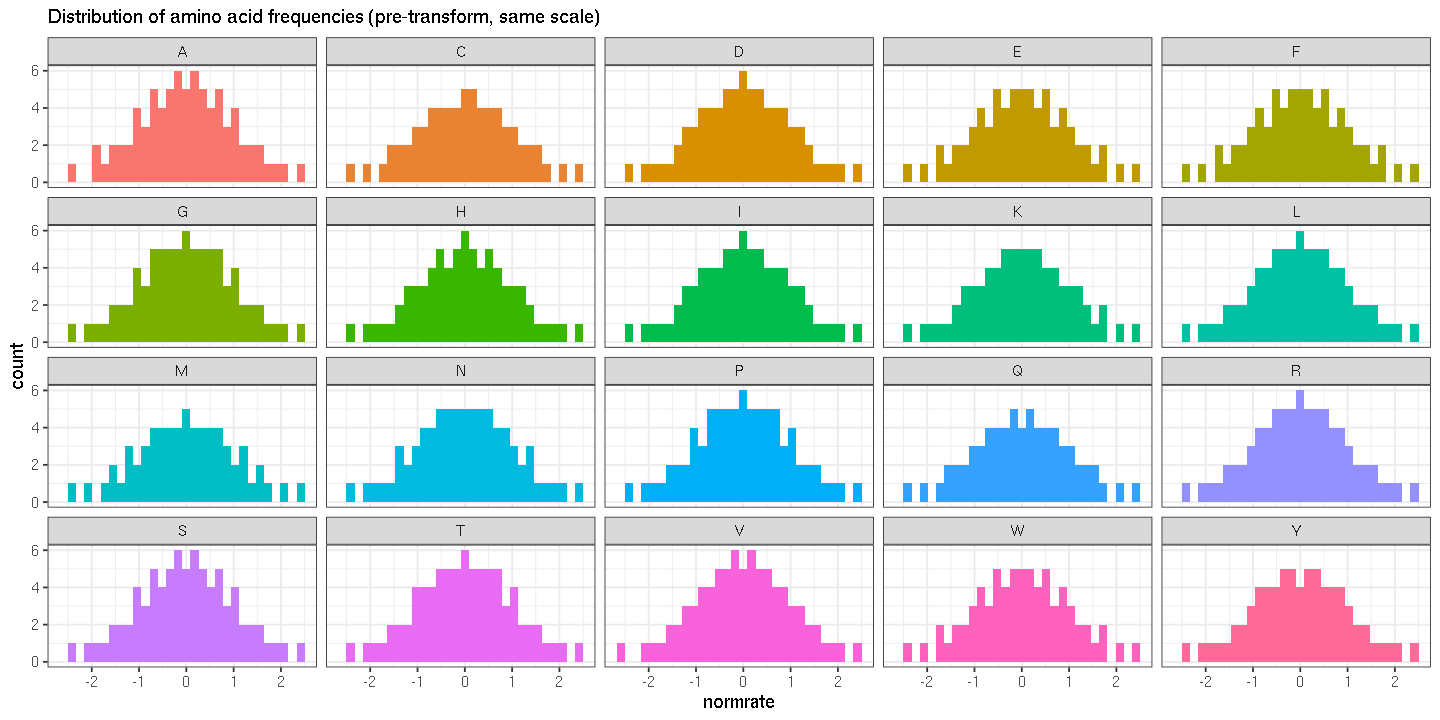

In [15]:
# the distributions of CDR3 amino acid frequencies of post-transformation.
#as you can see, the data is normally distributted.
options(repr.plot.width=12, repr.plot.height=6)
df <- pall
df %>% ggplot(aes(x=normrate,fill=AA))+
  geom_histogram(bins = 30)+
  facet_wrap(~AA)+
  theme_bw()+
  theme(legend.position = "none")+
  labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")


In [38]:
head(pall)

pos_length,normrate,AA
<chr>,<dbl>,<chr>
P105:12,-1.21678978,D
P107:12,0.08254853,D
P108:12,0.46108609,D
P109:12,0.82760412,D
P113:12,0.53578773,D
P114:12,1.28908534,D


In [ ]:
#---------trying the same with dplyr--------

cdrs_test <- pall %>% filter(po)